In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import feature_selection as fs
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
import prep_utils as pu
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pointbiserialr
from sklearn.feature_selection import RFE

PAST_YEARS = 1
TEST_YEAR = 10

In [2]:
db = sqlite3.connect("db/ac.db")
db_cur = db.cursor()

[df_awards, df_coaches, df_players_teams, df_players, df_series_post, df_teams_post, df_teams] = pu.db_to_pandas(db)

In [3]:
# Transform all possible attributes into percentages. (Made / Attempted) & (Offensive & Defensive Rebound %)
df_new_teams = pu.prepare_teams(df_teams,df_teams_post,PAST_YEARS)

df_new_teams = fs.fs_teams(df_new_teams)

df_new_teams = pu.playoff_rank(df_new_teams,df_teams,PAST_YEARS)
df_team_results = df_new_teams[["year","tmID","confID","playoff","rank","team_playoffs_count","playoff_rank"]]


Dropping divID in Teams...
1       True
142     True
0      False
2      False
3       True
4       True
5       True
6      False
7      False
8      False
12     False
143     True
9      False
10     False
11     False
13      True
14      True
15     False
16      True
23     False
144     True
17      True
18      True
19      True
20      True
21      True
22      True
24     False
33      True
25     False
26     False
27      True
28      True
29      True
30      True
31      True
32      True
34      True
35      True
36      True
37      True
38     False
39      True
40      True
41     False
42     False
43     False
52      True
145     True
44     False
45      True
46     False
47     False
48      True
49      True
50      True
51      True
53      True
62      True
146     True
54      True
55      True
56      True
57      True
58      True
59      True
60     False
61      True
63     False
64      True
65     False
66     False
75     False
147     True
67     Fals

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
df_new_coaches = pu.prepare_coaches(df_coaches, df_awards,PAST_YEARS)
df_new_coaches = pu.group_coaches(df_new_coaches)
df_new_coaches.drop("coachID", axis = 1, inplace = True)

df_final_coaches = df_new_coaches.copy()
df_final_coaches.columns = df_final_coaches.columns.str.lower()

Dropping Attribute lgID in Coaches...
Creating attribute coach previous regular season win ratio...
Creating attribute coach playoffs win ratio...
Creating attribute coach playoffs count...
Creating attribute coach awards count...
Dropping attribute post_wins..
Dropping attribute post_losses..
Dropping attribute won..
Dropping attribute lost..

Coaches Null Verification:
year                    0
tmID                    0
coachID                 0
coach_reg_wr            0
coach_po_wr             0
coach_playoffs_count    0
coach_awards            0
dtype: int64


In [ ]:
df_new_players_teams = pu.prepare_player_teams(df_players_teams,df_awards,PAST_YEARS)
# How the team performed in the previous year
previous_team_ratings = pu.final_team_ratings(df_players_teams,df_awards, df_players, df_teams, PAST_YEARS)

# How the players performed in the previous year
previous_team_player_ratings = pu.final_player_team_ratings(df_teams, df_players_teams, df_awards, df_players, PAST_YEARS)



df_players = df_new_players_teams.copy()
df_players = fs.fs_players(df_players,0.2)
df_players = df_players[df_players['year'] != 1]


df_team_results.columns = df_team_results.columns.str.lower()
merged_data = pd.merge(df_players, df_team_results, on=['tmid', 'year'], how='left')
merged_data = pd.merge(merged_data, df_final_coaches, on=['tmid', 'year'], how='left')
merged_data = pd.merge(merged_data, previous_team_ratings, on=['tmid', 'year'], how='left')
merged_data = pd.merge(merged_data, previous_team_player_ratings, on=['tmid', 'year'], how='left')


Dropping Attribute lgID in Players_Teams...


#### Point Bisserial Correlation 
We will use this to check correlation between continuous attributes & target


team_players_rating: 72.70% correlation
total_assists: 36.39% correlation
total_gs: 32.71% correlation
total_points: 31.77% correlation
team_rating: 24.81% correlation
total_orebounds_pct: 12.93% correlation


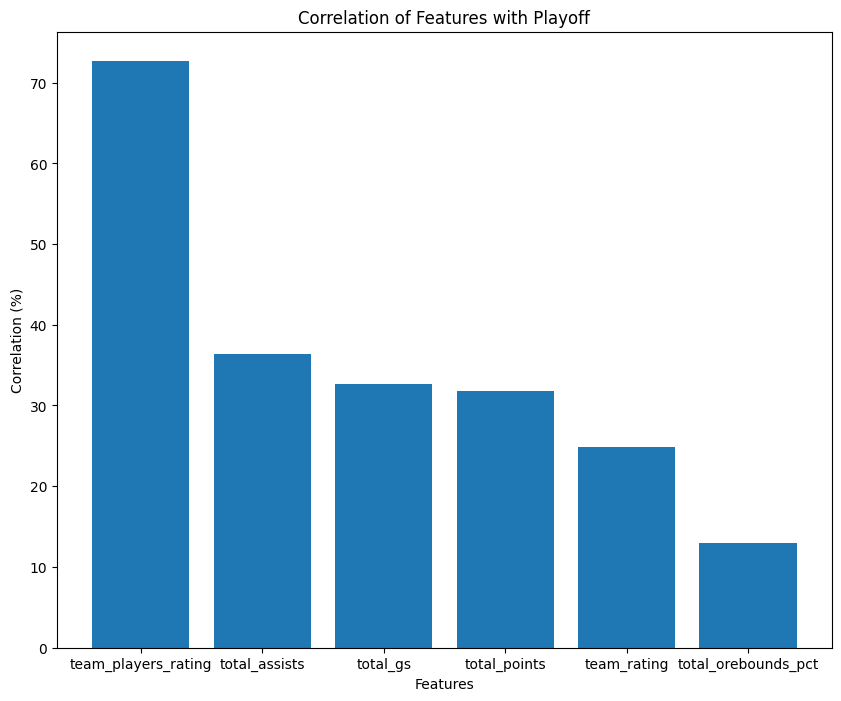

In [ ]:
fs.bisserial_corr(merged_data)

### Dividing the dataset in both train & test
We will be using year 10 and test and the remaining ones to train the model

In [ ]:
label_encoder = LabelEncoder()
merged_data['tmid'] = label_encoder.fit_transform(merged_data['tmid'])
merged_data['confid'] = label_encoder.fit_transform(merged_data['confid'])

x = merged_data.drop('playoff', axis=1)
y = merged_data['playoff']

x_train = merged_data[merged_data['year'].between(0, TEST_YEAR - 1)].drop('playoff', axis=1)
y_train = merged_data[merged_data['year'].between(0, TEST_YEAR - 1)]['playoff']

x_test = merged_data[merged_data['year'] == TEST_YEAR].drop('playoff', axis=1)
y_test = merged_data[merged_data['year'] == TEST_YEAR]['playoff']

### RFE
We will running RFE on the different models to find out which features produce the best results

In [ ]:
min_features = 5
print(merged_data.columns)

rfe_classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42,max_iter=10000),
    'Support Vector Machine': SVC(random_state=42, kernel='linear'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
}

classifiers_features = {}

total_features = len(x_train.columns)
for model_name, model in rfe_classifiers.items():
    print(f"\033[1mModel: {model_name}\033[0m")
    
    results = []

    for i in range(min_features, total_features):
        rfe = RFE(model, n_features_to_select=i)
        rfe.fit(x_train, y_train)
        
        selected_features = set(x_train.columns[rfe.support_])
        selected_features.add("tmid")
        selected_features.add("year")
        selected_features = list(selected_features)

        model.fit(x_train[selected_features], y_train)

        accuracy = model.score(x_test[selected_features], y_test)

        results.append((selected_features, accuracy))

    # Sort the results based on accuracy in descending order
    results = sorted(results, key=lambda x: x[1], reverse=True)

    classifiers_features[model_name] = results[0][0]
    # Print the results
    for features, accuracy in results[:3]:
        print("Selected Features:", features)
        print("Accuracy:" + str(accuracy) + '\n')

Index(['year', 'tmid', 'player_awards', 'total_minutes', 'total_points',
       'total_assists', 'total_steals', 'total_blocks', 'total_turnovers',
       'total_pf', 'total_dq', 'total_gs', 'total_gp', 'total_fg_pct',
       'total_ft_pct', 'total_three_pct', 'total_orebounds_pct',
       'total_drebounds_pct', 'confid', 'playoff', 'rank',
       'team_playoffs_count', 'playoff_rank', 'coach_reg_wr', 'coach_po_wr',
       'coach_playoffs_count', 'coach_awards', 'team_rating',
       'team_players_rating'],
      dtype='object')
Model: Random Forest
Selected Features: ['total_drebounds_pct', 'total_minutes', 'team_players_rating', 'total_gp', 'team_rating', 'year', 'coach_playoffs_count', 'total_points', 'coach_reg_wr', 'total_gs', 'total_orebounds_pct', 'total_fg_pct', 'total_turnovers', 'total_blocks', 'total_ft_pct', 'total_assists', 'total_steals', 'total_three_pct', 'tmid']
Accuracy:0.9230769230769231

Selected Features: ['total_drebounds_pct', 'total_minutes', 'team_players_ratin

Since RFE doesn't work with KNN, we will be using SelectKBest which produces the same process

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
results = []

for i in range(min_features, total_features):
    knn = KNeighborsClassifier()

    selector = SelectKBest(score_func=mutual_info_classif, k=i)
    selector.fit(x_train, y_train)


    selected_features = set(x_train.columns[selector.get_support()])
    selected_features.add("tmid")
    selected_features.add("year")
    selected_features = list(selected_features)

    knn.fit(x_train[selected_features], y_train)

    accuracy = knn.score(x_test[selected_features], y_test)

    results.append((selected_features, accuracy))

results = sorted(results, key=lambda x: x[1], reverse=True)

classifiers_features["K-Nearest Neighbors"] = results[0][0]

# Print the best 3 results
for features, accuracy in results[:3]:
    print("Selected Features:", features)
    print("Accuracy:" + str(accuracy) + '\n')

Selected Features: ['team_players_rating', 'year', 'coach_playoffs_count', 'playoff_rank', 'total_assists', 'tmid']
Accuracy:0.6923076923076923

Selected Features: ['rank', 'coach_awards', 'team_players_rating', 'confid', 'year', 'coach_po_wr', 'playoff_rank', 'tmid']
Accuracy:0.6923076923076923

Selected Features: ['coach_reg_wr', 'rank', 'total_minutes', 'total_blocks', 'team_players_rating', 'total_gs', 'year', 'coach_po_wr', 'coach_playoffs_count', 'total_points', 'tmid', 'playoff_rank', 'total_assists', 'total_steals']
Accuracy:0.6923076923076923



#### GridSearch
Now that we know the best features for each model, we will use gridsearch to fine tune its parameters.

In [ ]:
#best_params = fs.grid_search(classifiers_features,x_train,x_test,y_train,y_test)
#print(best_params)

# Random Forest -> {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}

# Logistic -> {'C': 100, 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear'}

# SVM -> {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

# Gradient -> {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}

# KNN ->  {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}

import time

model_params = {'Random Forest': {'random_state':42, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}, 'Logistic Regression': {'random_state':42, 'C': 100, 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 10000}, 'Support Vector Machine': {'random_state':42, 'C': 10, 'gamma': 'scale', 'kernel': 'linear'}, 'Gradient Boosting': {'random_state':42,'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}, 'K-Nearest Neighbors': {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}}

final_classifiers = {
    'Random Forest': RandomForestClassifier(random_state =42),
    'Logistic Regression': LogisticRegression(random_state =42),
    'Support Vector Machine': SVC(random_state =42),
    'Gradient Boosting': GradientBoostingClassifier(random_state =42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
}

for model_name, model in final_classifiers.items():
    start = time.time()
    model.fit(x_train[classifiers_features[model_name]], y_train)
    y_pred = model.predict(x_test[classifiers_features[model_name]])
    
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    end = time.time()
    print(f'Accuracy for {model_name}: {accuracy}')
    print(f'AUC for {model_name}: {auc}')
    print(end-start)


Accuracy for Random Forest: 0.9230769230769231
AUC for Random Forest: 0.9
0.08751559257507324
Accuracy for Logistic Regression: 0.7692307692307693
AUC for Logistic Regression: 0.7375
0.020001649856567383
Accuracy for Support Vector Machine: 0.6153846153846154
AUC for Support Vector Machine: 0.575
0.003000020980834961
Accuracy for Gradient Boosting: 0.8461538461538461
AUC for Gradient Boosting: 0.8375
0.04499959945678711
Accuracy for K-Nearest Neighbors: 0.6923076923076923
AUC for K-Nearest Neighbors: 0.675
0.003000020980834961


C:\Users\ricar\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
